# NER with Evolutionary Algorithms


- Take example of conll 2002 &check;
- Transform example to Doument object
  - Create vocabulary from corpus text
  - Create vocabulary from corpus iob
  - Create vocabulary from file &check;
  - Create vocabulary from spacy
  - Create vocabulary from conll2002 &check;
  - Create vocabulary from spacy after preprocessing
- Transform Document object to array &check;
- Create text documents to WORD POS DEPREL
  - Train neural network with word lemma pos deprel to predict next token
- Generate rules using genetic algorithm
  - Generate init population
    - Create chromosome
    - Select next token:
      - Get transition data
      - Filter samples evaluating their quality
  - Create fitness function
    - Evaluate fitness function
  - Create mutation function
    - Change token
    - Change transition
  - Create crossover function
    - Change token
    - Change transition
  - Evaluate population
    - Evaluate fitness
    - Select best samples
- Join rules
  - Support vector machine


## Config


In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from typing import List,TYPE_CHECKING,Iterable,Dict, Optional
import numpy as np

In [16]:
import torch
from transformers import AutoModel, AutoTokenizer

In [17]:
model_path = "symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli"
cache_dir = "/home/jraba/Dev/cache-ml-models"
tokenizer = AutoTokenizer.from_pretrained(model_path, cache_dir=cache_dir)
model_ml = AutoModel.from_pretrained(model_path, cache_dir=cache_dir)

In [18]:
from functools import lru_cache
import torch.nn.functional as F

embedding_size = 32

@lru_cache(maxsize=1000)
def get_ml_embedding(sentence: str) -> torch.Tensor:
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        # First element of model_output contains all token embeddings
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        )
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    encoded_input = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=8,
    )
    # Compute token embeddings
    with torch.no_grad():
        model_output = model_ml(**encoded_input)
    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    # Normalize embeddings
    # sentence_embeddings = F.normalize(
    #     sentence_embeddings.reshape(embedding_size, -1).mean(axis=1).expand(1, -1),
    #     p=2,
    #     dim=1,
    # )
    sentence_embeddings = sentence_embeddings.reshape(embedding_size, -1).mean(axis=1).expand(1, -1)
    return sentence_embeddings[0]


@lru_cache(maxsize=1000)
def similarity(sentence1: str, sentence2: str) -> float:
    vector1 = get_ml_embedding(sentence1)
    vector2 = get_ml_embedding(sentence2)
    return (vector1 @ vector2).sum() / (vector1.norm() * vector2.norm())

In [19]:
def get_ml_embeddings(sentence: List[str]) -> torch.Tensor:
    return torch.stack([get_ml_embedding(s) for s in sentence])

In [20]:
from ga_ner import linguistic_features as lf
num_docs = 10

In [21]:
entity_names = []
with open("entity_names.txt", "r") as file:
    for line in file:
        entity_names.append(line.strip())
entity_map = np.array(["O"] + entity_names)
print(entity_map)

['O' 'PER' 'MISC' 'ORG' 'LOC']


In [22]:
entity_map_inv = {entity: index for index, entity in enumerate(entity_map)}
entity_map_inv

{'O': 0, 'PER': 1, 'MISC': 2, 'ORG': 3, 'LOC': 4}

## Transform data


In [23]:
from ga_ner.models import Vocabulary

enconding = "iso-8859-1"
vocab = Vocabulary.from_iob("data/train/esp.train.txt", enconding, num_docs)

### Evolutinary NER Rules


1. Take a example of conll 2002
2. Create Ner rule with samples using genetic algorithm
3. Label data with rules
4. Train neural network with data labeled with rules
5. Select samples with high precision
6. repeat steps 2-5 with selected samples until precision is high enough


In [24]:
import numpy as np
from ga_ner.models import GANER, Document, Corpus, Vocabulary
import spacy
from spacy.tokens import DocBin

if TYPE_CHECKING:
    from spacy.tokens import Doc as SpacyDoc

### 1. Take a example of conll 2002

1. Load conll2002 to spacy documents
2. Load Vocabulary from conll2002
3. Take random samples from spacy documents
4. Convert Spacy models to Corpus object from samples


##### 1. Load conll2002 to spacy models


In [25]:
nlp = spacy.load("es_dep_news_trf", exclude=["ner"])

In [26]:
# load from disk
# Load the DocBin from the file
doc_bin_loaded = DocBin().from_disk("./data/ner_ea.spacy")
# Simple load
spacy_ner_doc = list(doc_bin_loaded.get_docs(nlp.vocab))

In [27]:
samples_len = len(spacy_ner_doc)
samples_len

8323

##### 2. Load Vocabulary from conll2002


In [28]:
vocabulary = Vocabulary.from_file(
    "data/vocabs/conn-2002-uncased-vocab.txt", include_special=False
)

2784 = Vocab

62 = Dep

19 = POS

2703 = Word


##### 3. Take random samples from spacy documents


In [29]:
sample_is_complete_1 = np.zeros(samples_len, dtype=bool)

In [30]:
np.random.seed(42)
selected_indices = np.random.choice(samples_len, size=samples_len, replace=False)

In [31]:
#  Select index based in entity type
# Count number of entities by type
# TODO convert to function
from collections import Counter

entity_counter = Counter()

for doc in spacy_ner_doc:
    for ent in doc.ents:
        entity_counter[ent.label_] += 1

# Normalize
total_entities = sum(entity_counter.values())
for k in entity_counter:
    entity_counter[k] = entity_counter[k] / total_entities

# Select indices
# Add index if entity type is less proporcional
# Selected indices remove
# Do until all entity types are selected
selected_indexes_stratified = []
was_selected = np.zeros(samples_len, dtype=bool)
entity_selected_counter = Counter()
while not was_selected.all():
    for i in selected_indices:
        doc = spacy_ner_doc[i]
        if not was_selected[i]:
            if len(doc.ents)==0:
                was_selected[i] = True
                continue
            total_selected = sum(entity_selected_counter.values())
            if total_selected==0 or entity_selected_counter[doc.ents[0].label_]/total_selected < entity_counter[doc.ents[0].label_]:
                selected_indexes_stratified.append(i)
                for ent in doc.ents:
                    was_selected[i] = True
                    entity_selected_counter[ent.label_] += 1

In [32]:
entity_counter

Counter({'LOC': 0.26141078838174275,
         'ORG': 0.39312692839663793,
         'PER': 0.2298648792424726,
         'MISC': 0.11559740397914672})

In [33]:
selected_indices_1 = selected_indexes_stratified[:10]
selected_indices_1

[7000, 1346, 5204, 4952, 7423, 4509, 7468, 533, 4619, 1385]

##### 4. Convert Spacy models to Corpus object


In [34]:
def sample_spacy_docs(
    docs: List["SpacyDoc"],
    selected_indices: Iterable[int],
    sample_is_complete: Iterable[int],
    spacy_ner_doc: List["SpacyDoc"],
) -> Iterable["SpacyDoc"]:
    """
    Sample a list of spacy documents of selected index.
    If doc is not complete, it will be completed in spacy pipeline.
    """
    spacy_models = [
        docs[index] for index in selected_indices if not sample_is_complete[index]
    ]

    # Complement spacy documents
    spacy_models = list(
        nlp.pipe(spacy_models, disable=["tok2vec", "tagger", "attribute_ruler"])
    )

    # Reassign spacy document
    index_doc = 0
    for index in selected_indices:
        if not sample_is_complete[index]:
            spacy_models[index_doc] = spacy_ner_doc[index]
            sample_is_complete[index] = True
            index_doc += 1
        yield docs[index]

In [35]:
corpus_1 = Corpus.from_spacy_docs(
    [spacy_ner_doc[i] for i in selected_indices_1],
    total_samples=len(selected_indices_1),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    emb_size=embedding_size,
)

In [36]:
vocab_ent = Vocabulary.from_list(list(corpus_1.entities.keys()), include_special=False)

In [37]:
vocab_ent

In [38]:
corpus_1.documents[0].unk_id

tensor([-0.0702, -0.0671,  0.0422,  0.0751, -0.0545, -0.0136, -0.0125,  0.0699,
         0.0931,  0.0150, -0.1770, -0.0753,  0.1406, -0.0690,  0.0584,  0.0122,
         0.0424, -0.0066, -0.0469,  0.2698, -0.0530, -0.1566, -0.1648,  0.0829,
         0.0109, -0.0457, -0.1312, -0.0837,  0.0892, -0.1082,  0.0966, -0.0172])

### 2. Create Ner rule with samples using genetic algorithm

1. From corpus create datasets by entities to predict
   - From datasets:
     - Convert to array
     - Get representation of documents for entities to predict
1. To Train Genetic Algorithm for entity
1. Get best genetic ner rules


**Candidate Words**: are the words that can be used activate a new gene in the rule, that word are taken from words that create the entity to predict.

**Parent Population** are created using entities in training corpus. Use diferent lenfth of entities. For First loop create tuples with length equal 1 for each feature of token then create 3 individuals (3x1). For second loop create tuples with length equals 2 for each feature and combinate posibilities, then create 18 individual (3²x2), repetead until complete the length parent population.

##### 1. From corpus create datasets by entities to predict


### Structure


Each individual has next structure:

    - first token is size of rule or number of segments will be used
    - second is fitness value
    - third is entity type to predict
    - next tokens are segments of rule

Each segment has next structure:

    - first token indicate if a entity is predicted
    - second token is value for linguistic feature type
    - next tokens are embedding values for linguistic feature value

An individual has 7 seven segments. To indicate that there is an entity is used value 1 else 0. The segments that are not used are filled with 0. Size of segment is 2 + embedding size.

## Example:

An individual which size is 3, fitness value is 0.5, entity type is PER, and has 3 segments wich embedding size is 2.
The first segment is for word feature and has value "John" and embedding [0.1, 0.2].
The second segment is for pos feature and has value "NOUN" and embedding [0.4, 0.5].
The third segment is for dep feature and has value "aux" and embedding [0.7, 0.8].
The 2 fisrt segments are indicators for entity prediction.

| 3.0 | 0.5 | 1.0 | 1.0 | 0.0 | 0.1 | 0.2 | 1.0 | 1.0 | 0.4 | 0.5 | 0.0 | 2.0 | 0.7 | 0.8 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |

Size of individual is 3 + 7 \* (2 + 2) = 31


In [39]:
def create_candidate_words(
        corpus:Corpus,
        embedding_size:int,
        candidate_words: Optional[np.ndarray] = None, 
        save_path: str = None):
    """
    Create candidate words from corpus
    :param corpus_1: corpus_1
    :param candidate_words: candidate words
    :param save_path: save path
    :return: candidate words
    """
    if candidate_words is None:
        candidate_words = np.empty((0, embedding_size + 1))
    for document in corpus.documents:
        for entity in document.entities:
            for index_entiy in range(entity.start, entity.end):
                for index_feature in range(3):
                    candidate_words = np.vstack(
                        (
                            candidate_words,
                            np.append(
                                index_feature,
                                document.tokens[index_entiy][index_feature].value,
                            ),
                        )
                    )
    if save_path:
        np.savetxt(save_path, candidate_words, fmt="%s", delimiter=",")
    return candidate_words

In [41]:
# Load candidate words
candidate_words = np.loadtxt(
    "data/train/esp.train.candidate_words", delimiter=",", dtype=np.float32
)

In [42]:
from typing import List
from tqdm.auto import tqdm
from itertools import product

def create_parent_population(
        population_size, 
        documents:List[Document],
        cromossome_size, 
        base_population:Optional[np.ndarray]=None):
    parent_population = np.zeros((population_size, cromossome_size), dtype=np.float32)
    # Initialize population
    cur_ind_len = 1
    cur_pop_len = 0
    fishished = False
    any_entity = True
    previous_start = 0
    if base_population is not None:
        cur_pop_len = base_population.shape[0]
        parent_population[:cur_pop_len] = base_population

    if len(documents) == 0:
        return parent_population
    
    entity_len = np.array([len(document.entities) for document in documents])
    
    while not fishished and any_entity:
        any_entity = False
        for document in documents:
            for entity in document.entities:
                fishished = fishished or cur_pop_len >= population_size
                if entity.end - entity.start - previous_start >= cur_ind_len  and not fishished and entity.start - previous_start > 0:
                    any_entity = True
                    feature_values = []
                    for index_feature in range(entity.start-previous_start, entity.start+cur_ind_len):
                        feature_values.append(range(3))

                    for combination_value in product(*feature_values):
                        parent_population[cur_pop_len, 0] = cur_ind_len
                        parent_population[cur_pop_len, 1] = 0
                        parent_population[cur_pop_len, 2] = entity_map_inv[entity.label]
                        for index_combination, index_feature in enumerate(combination_value):
                            start_index = 3 + index_combination * (embedding_size + 2)
                            end_index = start_index + (embedding_size + 2)
                            index_token = entity.start + index_combination - previous_start
                            entity_id = entity_map_inv[entity.label] if index_token >= entity.start else 0
                            parent_population[cur_pop_len][start_index] = entity_id
                            parent_population[cur_pop_len][start_index+1] = index_feature
                            parent_population[cur_pop_len][start_index+2:end_index] = document.tokens[index_token][index_feature].value
                        cur_pop_len += 1

                        if cur_pop_len >= population_size:
                            fishished = True
                            break
        cur_ind_len += 1
        if not any_entity and cur_pop_len < population_size:
            any_entity = True
            cur_ind_len = 1
            previous_start += 1
        # If start index is greater than entity length, then reset
        if previous_start >= entity_len.max():
            previous_start = 0
            
    return parent_population

In [43]:
from itertools import product

len(list(product(range(3), range(3), range(3), range(3))))

81

In [44]:
for document in corpus_1.documents:
    for entity in document.entities:
        print(entity)

Entity(label=ORG, name=Lucchetti, start=5, end=6)
Entity(label=ORG, name=Grupo Luksic, start=10, end=12)
Entity(label=LOC, name=Argentina, start=33, end=34)
Entity(label=LOC, name=Perú, start=35, end=36)
Entity(label=LOC, name=Chile, start=37, end=38)
Entity(label=MISC, name=Educación, Cultura. Deportes, start=10, end=13)
Entity(label=PER, name=Pilar del Castillo, start=14, end=17)
Entity(label=PER, name=Bonet, start=23, end=24)
Entity(label=ORG, name=Consejo de Ministros, start=25, end=28)
Entity(label=MISC, name=Oferta Pública de Suscripción, start=20, end=24)
Entity(label=MISC, name=OPS, start=25, end=26)
Entity(label=ORG, name=Federación Nacional de Industrias Lácteas, start=4, end=9)
Entity(label=ORG, name=FENIL, start=10, end=11)
Entity(label=PER, name=Pedro Ara, start=13, end=15)
Entity(label=ORG, name=Inlac, start=31, end=32)
Entity(label=LOC, name=Ohmhajer, start=21, end=22)
Entity(label=ORG, name=Etiopía, start=31, end=32)
Entity(label=ORG, name=Eritrea, start=39, end=40)
Ent

In [52]:
def read_input_txt(input_filename, target_filename, metadata_filename, num_docs, max_size_doc, embedding_size):
    doc_dataset = np.zeros((num_docs, max_size_doc * embedding_size * 3), dtype=np.float32)
    target_doc = np.zeros((num_docs, max_size_doc), dtype=np.int32)
    metadata_doc = np.zeros((num_docs, 4), dtype=np.int32)
    with open(input_filename) as input_file, open(target_filename) as target_file, open(
    metadata_filename
    ) as metadata_file:
        for doc_index, line in enumerate(input_file):
            input_doc = np.array([float(x) for x in line.split(",")], dtype=np.float32)
            doc_dataset[doc_index, : input_doc.shape[0]] = input_doc
        for doc_index, line in enumerate(target_file):
            line_target = np.array([int(x) for x in line.split(",")])
            target_doc[doc_index, : line_target.shape[0]] = line_target
        for doc_index, line in enumerate(metadata_file):
            line_metadata = np.array([int(x) for x in line.split(",")])
            metadata_doc[doc_index, : line_metadata.shape[0]] = line_metadata
    return doc_dataset, target_doc, metadata_doc

max_size_doc = 172
doc_dataset, target_doc, metadata_doc = read_input_txt("input.txt", "target.txt", "metadata.txt", num_docs, max_size_doc, embedding_size)
assert doc_dataset.shape == (num_docs, max_size_doc * embedding_size * 3)
assert target_doc.shape == (num_docs, max_size_doc)
assert metadata_doc.shape == (num_docs, 4)

In [53]:
metadata_doc

array([[ 46,   5, 100,   0],
       [ 34,   4, 100,   1],
       [ 34,   2, 100,   2],
       [ 46,   4, 100,   3],
       [ 41,   3, 100,   4],
       [  8,   2, 100,   5],
       [ 46,   1, 100,   6],
       [ 49,   4, 100,   7],
       [ 29,   1, 100,   8],
       [ 39,   3, 100,   9]], dtype=int32)

##### 2. To Train Genetic Algorithm for entity


<p style="text-align: center;">Individual fitness</p>

$$f_i=\frac{TP_i}{TP_i+FP_i} * \log_2(TP_i+FP_i)$$

<p style="text-align: center;">Sharing function</p>

$$
sh(d_{i,j}) = \left \{
    \begin{array}{l}
    1  - \frac{d_{i,j}}{\sigma_{share}}, d_{i,j} < {\sigma_{share}}  \\
    0, otherwise
    \end{array}
\right \}
$$

<p style="text-align: center;">Individual shared fitness</p>

$$f^t_i = \frac{f_i}{\sum_{j=1}^N sh(d_{i,j})}$$


$$
  \text{fitness}(\text{ind}, \text{doc}) = \begin{cases}
    -1.0                                                                                                                                                                                                 & \text{if } \text{retrive\_doc} = 0 \\
    0.8 \times \text{Precision} + 0.1 \times \frac{\log_2(\text{ind size})}{\log_2(7)} + 0.1 \times ind\_seq & \text{otherwise}
  \end{cases}
$$

<div style="text-align: center;">

<p style="text-align: center;">Island model</p>

![image.png](./img/island_ae.svg)

</div>


In [54]:
doc_dataset.shape

(10, 16512)

In [55]:
from typing import List, Dict, Tuple, Iterable
import numpy as np

def slice_doc(
    doc: np.ndarray,
    rule: np.ndarray,
    doc_size: int,
    embedding_size: int,
    num_features: int = 3,
) -> Iterable[Tuple[int, int]]:
    """Return indices where entity is located in the document."""
    rule_size: int = int(rule[0])
    entity_mask = np.zeros(rule_size, dtype=np.int16)
    # individual_data = rule[3 : 3 + rule_size].reshape(-1, 1)
    # Fill individual data, ignore first 2 elements for each segment
    # TODO convert to function
    individual_data = np.zeros(rule_size * embedding_size, dtype=np.float32)
    feature_array = np.zeros(rule_size, dtype=np.int32)
    for index in range(rule_size):
        start_index = index * (embedding_size + 2) + 2 + 3
        end_index = start_index + embedding_size
        individual_data[index * embedding_size : (index + 1) * embedding_size] = rule[
            start_index:end_index
        ]
        feature_array[index] = rule[start_index-1]
    # Set mask of entity
    for index in range(rule_size):
        entity_mask[index] = rule[index * (embedding_size + 2) + 3]

    similarity_threshold: float = 0.8
    for index in range(0, doc_size - rule_size + 2):
        start_index = index * embedding_size * num_features
        end_index = (index + rule_size) * embedding_size * num_features
        sliced_doc = np.zeros(rule_size * embedding_size, dtype=np.float32)
        for index_feature in range(feature_array.shape[0]):
            feature = feature_array[index_feature].item()
            displacement = feature * embedding_size
            
            segment_start = index_feature * embedding_size
            index_segment_doc = (
                start_index + displacement + index_feature * embedding_size * num_features
            )
            if index_segment_doc >= doc.shape[0]:
                print(f"{index} Doc size is too long ", doc_size)
                break
            if end_index < index_segment_doc + embedding_size:
                raise ValueError("Index out of range")
            if sliced_doc[segment_start : segment_start + embedding_size].shape != doc[
                index_segment_doc : index_segment_doc + embedding_size
            ].shape:
                raise ValueError("Max len is too small")
            sliced_doc[segment_start : segment_start + embedding_size] = doc[
                index_segment_doc : index_segment_doc + embedding_size
            ]

        # assert sliced_doc.shape == (rule_size * embedding_size, num_features)

        index_doc = index + 1
        # Cosine similarity
        similarity: np.ndarray = sliced_doc @ individual_data
        similarity /= np.linalg.norm(sliced_doc) * np.linalg.norm(
            individual_data
        )

        if (similarity > 1+1e-6).any():
            raise ValueError("Similarity greater than 1")

        if (similarity > similarity_threshold).any():
            for index_rule in range(rule_size):
                start_index = index_doc + index_rule
                end_index = start_index + 1
                yield start_index, end_index, entity_mask[index_rule].item()


In [56]:

from tqdm.auto import trange, tqdm
def get_all_targets(val_doc_dataset, val_target_doc, val_metadata_doc, entity_map):
    target_data_all = np.array([], dtype=int)
    for index_doc in trange(val_doc_dataset.shape[0]):
        if val_target_doc[index_doc].sum() == 0:
            continue
        doc_size = val_metadata_doc[index_doc, 0].item()
        target_data = val_target_doc[index_doc][1:doc_size+1]
        # get rules for each entity
        # get votes from rules
        target_data_all = np.concatenate((target_data_all, target_data))

    return entity_map[target_data_all].tolist()


def majority_vote(
        val_doc_dataset, 
        val_target_doc, 
        val_metadata_doc, 
        entity_map, 
        num_rules:int,
        array_rules:np.ndarray,
        array_fitness:np.ndarray,
        max_len:int=172,
        ):
    votes_all = np.array([], dtype=int)
    fitness_votes_all = np.array([], dtype=int)
    doc_len_list = []
    fitness_active = np.zeros((num_rules,), dtype=bool)

    for index_doc, array_doc in enumerate(tqdm(val_doc_dataset)):
        if val_target_doc[index_doc].sum() == 0:
            continue

        doc_size = min(val_metadata_doc[index_doc, 0].item(), max_len - 1)
        doc_len_list.append(array_doc[0])
        
        # get votes from rules
        votes = np.zeros((doc_size, 5), dtype=float)
        fitness_votes = np.zeros((val_metadata_doc[index_doc][0], 5), dtype=float)
        for index_rule in range(array_rules.shape[0]):
            if array_fitness[index_rule] < 0.8:
                continue
            slices: Iterable[Tuple[int, int, int]] = slice_doc(
                array_doc,
                array_rules[index_rule],
                doc_size=doc_size,
                embedding_size=embedding_size,
            )
            for start, end, entity_id in slices:

                votes[start - 2 : end - 2, int(entity_id)] += 1
                fitness_votes[start - 2 : end - 2, int(entity_id)] += array_fitness[index_rule]
                
                fitness_active[index_rule] = True


        votes_all = np.vstack((votes_all, votes)) if votes_all.size else votes
        fitness_votes_all = np.vstack((fitness_votes_all, fitness_votes)) if fitness_votes_all.size else fitness_votes

    # Predict with majority vote using the best rules
    predict = []
    # If column 0 is 0, fill with mean of the other columns
    # If column 0 is less than 0.5, fill with 0.5
    means = votes_all.sum(axis=1)*.5
    arg_max_votes = votes_all.argmax(axis=1)
    predict = entity_map[
        np.where(
        votes_all.max(axis=1) > means,
        arg_max_votes,
        0)].tolist()

    return predict, votes_all,  fitness_votes_all

In [57]:
def get_confidence_segments(
        confidence_all_votes:np.ndarray, 
        val_metadata_doc:np.ndarray, 
        num_files:int, 
        predict:List[str]
        ):
    confidences_votes = []
    start_doc = 0
    min_segment_len = 3
    filter_votes = np.any(confidence_all_votes > 0.8, axis=1).reshape(-1,1)
    for index_row, doc_len in enumerate(val_metadata_doc[:, 0]):
        end_doc = start_doc + doc_len
        # If filter are consecutive and have a minimum length then add to confidences_votes
        current_secuence = 0
        for filter_votes_index, secuencuence_index in enumerate(range(start_doc, end_doc)):
            if filter_votes[secuencuence_index]:
                current_secuence += 1
            else:
                if current_secuence >= min_segment_len:
                    
                    confidences_votes.append(( 
                        index_row, 
                        confidence_all_votes[
                            range(secuencuence_index - current_secuence, secuencuence_index)
                            ].max(axis=1).mean(),
                        list(range(filter_votes_index - current_secuence, filter_votes_index)),
                        np.array(predict)[range(secuencuence_index - current_secuence, secuencuence_index)]
                        ))
                current_secuence = 0

        start_doc = end_doc
    return confidences_votes

In [58]:
# Create a custom function to sort confidences_votes by confidence (1) and length of sentence (2). The function will used by sorted() function.
from functools import cmp_to_key
def sort_confidence_votes(a, b):
    # Sort by confidence
    if a[1] > b[1]:
        return -1
    elif a[1] < b[1]:
        return 1
    else:
        # Sort by length of sentence
        if len(a[2]) > len(b[2]):
            return -1
        elif len(a[2]) < len(b[2]):
            return 1
        else:
            return 0      

In [59]:
# Remove entities
# Add Entities predicted by the model
# New spacy docs
from spacy.tokens import Doc
from spacy.tokens import Span


def extract_confidence_segment(
        spacy_ner_doc:List[Doc],
        confidence_votes:List[Tuple[int, float, List[int], List[str]]],
        num_new_documents:int,
        selected_indices:np.ndarray,
        metadata_doc:np.ndarray
        ):

    new_spacy_docs = []
    for condidence_doc in confidence_votes[:num_new_documents]:
        index_doc = condidence_doc[0]
        segment_tokens = condidence_doc[2]
        segment_label_tokens = condidence_doc[3]
        spacy_doc_index = selected_indices[metadata_doc[index_doc][3]]
        spacy_doc = spacy_ner_doc[spacy_doc_index]

        # Create a empty spacy doc
        words = [spacy_doc[index].text for index in segment_tokens]
        spaces = [spacy_doc[index].whitespace_ for index in segment_tokens]
        pos = [spacy_doc[index].pos_ for index in segment_tokens]
        deps = [spacy_doc[index].dep_ for index in segment_tokens]

        new_spacy_doc = Doc(spacy_doc.vocab, words=words, spaces=spaces, pos=pos, deps=deps)
        # Add the entities
        prev_label = None
        next_label = None
        end_index = 0
        for index, label in enumerate(segment_label_tokens):
            if prev_label != label:
                start_index = index
            if index + 1 < len(segment_label_tokens):
                next_label = segment_label_tokens[index + 1]
            else:
                next_label = None

            if label != "O":
                if next_label != label:
                    end_index = index + 1
                    new_spacy_doc.set_ents([Span(new_spacy_doc, start_index, end_index, label)], default="outside")
            prev_label = label

        new_spacy_docs.append(new_spacy_doc)
    return new_spacy_docs

In [60]:
def get_data_array(
        corpus:Corpus, 
        num_docs:int,
        max_size_doc:int, 
        embedding_size:int,
        suffix:str=""):
    corpus.to_text_array(
        input_filename=f"input{suffix}.txt",
        target_filename=f"target{suffix}.txt",
        metadata_filename=f"metadata{suffix}.txt",
    )
    return read_input_txt(
        input_filename=f"input{suffix}.txt",
        target_filename=f"target{suffix}.txt",
        metadata_filename=f"metadata{suffix}.txt",
        num_docs=num_docs,
        max_size_doc=max_size_doc,
        embedding_size=embedding_size,
    )

In [61]:
def get_new_documents(
        confidence_all_votes:np.ndarray,
        metadata_doc:np.ndarray,
        num_docs:int,
        predict:List[str],
        num_new_documents:int,
        spacy_docs:List[Doc],
        selected_indices:np.ndarray
):
    """
    1. Get confidence of each segment
    2. Sort by confidence
    3. Select the first n documents
    4. Create new documents
    5. Create new corpus
    """
    confidence_votes = get_confidence_segments(
        confidence_all_votes,
        metadata_doc,
        num_docs,
        predict,
    )
    sorted_confidence_votes = sorted(confidence_votes, key=cmp_to_key(sort_confidence_votes))
    return extract_confidence_segment(
        spacy_docs,
        sorted_confidence_votes,
        num_new_documents,
        selected_indices,
        metadata_doc
    )


In [62]:
def calculate_confidence_votes(votes_all:np.ndarray, fitness_votes_all:np.ndarray):
    total_row_votes = votes_all.sum(axis=1).reshape(-1,1)
    total_row_votes = np.where(
        total_row_votes == 0,
        1,
        total_row_votes
    )
    return fitness_votes_all / total_row_votes

In [ ]:
from sklearn.metrics import confusion_matrix

def save_confusion_matrix(
        corpus:Corpus,
        array_rules:np.ndarray,
        array_fitness:np.ndarray,
        entity_map:np.ndarray,
        max_size_doc:int,
        embedding_size:int,
        save_path:str,
        suffix="_train",
        ):
    """
    Save confusion matrix
    """
    doc_dataset, doc_target, doc_metadata = get_data_array(
        corpus=corpus,
        num_docs=len(corpus.documents),
        max_size_doc=max_size_doc,
        embedding_size=embedding_size,
        suffix=suffix
    )
    y_pred, _, _ = majority_vote(
        doc_dataset, doc_target, doc_metadata, entity_map, array_rules.shape[0], array_rules, array_fitness
    )
    y_true = get_all_targets(
        doc_dataset, doc_target, doc_metadata,entity_map)
    cm = confusion_matrix(y_true, y_pred, labels=entity_map)
    np.savetxt(save_path, cm, fmt="%d", delimiter=",")
    return cm     
        

In [65]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary
from ga_ner.utils.numba import select, fitness


gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)

# def training(spacy_ner_doc, max_len, embedding_size):
"""_summary_
1. Create candidate words
2. Create population base
3. Training NER Rules with population base
4. Save rule for each generation
5. Extract new documents segments from validation corpus
6. Update candidate words with new documents segments
7. Update population base with from Training NER Rules
8. Go to step 3
"""
doc_dataset, doc_target, doc_metadata = read_input_txt(
    input_filename="input.txt",
    target_filename="target.txt",
    metadata_filename="metadata.txt",
    num_docs=len(corpus_1.documents),
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
)
doc_dataset_expand = doc_dataset.copy()
target_doc_expand = doc_target.copy()
metadata_doc_expand = doc_metadata.copy()
# 1. Create candidate words
corpus_new = Corpus([])
candidate_words = create_candidate_words(
    corpus_1,
    embedding_size,
    save_path="data/train/esp.train.candidate_words")
# 2. Create population base
parent_population = create_parent_population(
    400,
    corpus_1.documents,
    cromossome_size=max_len
)
num_new_documents = len(corpus_1.documents)
gen_it = 0
candidate_words_expand = create_candidate_words(
        corpus=corpus_new,
        embedding_size=embedding_size,
        candidate_words=candidate_words,
        save_path="data/train/esp.train.candidate_words_new.txt",
    )
while num_new_documents < len(spacy_ner_doc)*0.8:
    # 3. Training NER Rules with population base
    
    ga_ner = GANER(
        map_inv_entity=None,#map_inv_entity
        n_population=400,
        max_len=max_len,
        mask_id=0,#corpus_1.documents[0].mask_id
        unknown_id=0,#corpus_1.documents[0].unk_id
        candidate_words=candidate_words_expand,
        random_state=42,
        n_top=100,
        threshold=0.8,
        select=select,
        fitness=fitness,
        num_threads=16,
        embedding_size=embedding_size,
    )
    ga_ner.train(
        doc_dataset_expand,
        target_doc_expand,
        metadata_doc_expand,
        max_iter=1000,
        tol=15,
        base_population=parent_population,
        num_islands=4,
        num_threads=16,
        save_path="data/rules",
        sufix=f"_{gen_it}"

    )
    # 2015_Book_IntroductionToEvolutionaryComp.pdf 80, 108, 120, 145,294
    array_rules = np.load(f"data/rules/best_population_{gen_it}.npy")
    array_fitness = np.load(f"data/rules/best_fitness_{gen_it}.npy") 
    # 5. Extract new documents segments from training corpus
    selected_indices_val = np.random.choice(
        range(10,len(spacy_ner_doc)), size=num_new_documents, replace=False
    )
    spacy_train_doc = [spacy_ner_doc[i] for i in selected_indices_val]
    corpus_train = Corpus.from_spacy_docs(
        spacy_train_doc,
        total_samples=len(spacy_train_doc),
        vocab=vocabulary,
        embeding_func=get_ml_embedding,
        emb_size=embedding_size
    )
    train_doc_dataset, train_doc_target, train_doc_metadata = get_data_array(
        corpus=corpus_train,
        num_docs=len(spacy_train_doc),
        max_size_doc=max_size_doc,
        embedding_size=embedding_size,
        suffix="_train"
    )
    predict, votes_all, fitness_votes_all = majority_vote(
        train_doc_dataset, train_doc_target, train_doc_metadata, entity_map, array_rules.shape[0], array_rules, array_fitness
    )
    
    confidence_all_votes = calculate_confidence_votes(
        votes_all,
        fitness_votes_all
    )
    
    new_spacy_docs = get_new_documents(
        confidence_all_votes,
        train_doc_metadata,
        num_docs,
        predict,
        num_new_documents,
        spacy_ner_doc,
        selected_indices_val
    )
    corpus_new = Corpus.from_spacy_docs(
        new_spacy_docs, 
        total_samples=len(new_spacy_docs), 
        vocab=vocabulary, 
        embeding_func=get_ml_embedding, 
        emb_size=embedding_size
    )
    # 6. Update candidate words with new documents segments
    candidate_words_expand = create_candidate_words(
        corpus_new,
        embedding_size=embedding_size,
        candidate_words=candidate_words,
        save_path="data/train/esp.train.candidate_words")
    # 7. Update population base with from Training NER Rules
    parent_population = create_parent_population(
        population_size=400,
        documents=corpus_new.documents,
        cromossome_size=max_len,
        base_population=ga_ner.population,
    )
    doc_dataset_new, doc_target_new,doc_metadata_new= get_data_array(
        corpus=corpus_new,
        num_docs=len(new_spacy_docs),
        max_size_doc=max_size_doc,
        embedding_size=embedding_size,
        suffix="_new"
    )
    doc_dataset_expand = np.vstack((doc_dataset, doc_dataset_new))
    target_doc_expand = np.vstack((doc_target, doc_target_new))
    metadata_doc_expand = np.vstack((doc_metadata, doc_metadata_new))
    # 8. Go to step 3
    num_new_documents += int(num_new_documents * 0.2)
    gen_it += 1
    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
predict, votes_all, fitness_votes_all = majority_vote(
    train_doc_dataset, train_doc_target, train_doc_metadata, entity_map, array_rules.shape[0], array_rules, array_fitness
)

  0%|          | 0/312 [00:00<?, ?it/s]

In [71]:
for doc in corpus_new.documents:
    print(doc.entities)


[Entity(label=ORG, name=Gobierno, start=7, end=8)]
[Entity(label=PER, name=cual ha financiado, start=2, end=5)]
[Entity(label=MISC, name=lo, start=3, end=4)]
[Entity(label=PER, name=Consejería, start=3, end=4)]
[Entity(label=PER, name=que están fuertemente, start=0, end=3)]
[Entity(label=PER, name=Luis Morales Reyes, start=0, end=3)]
[Entity(label=PER, name=Francolí, start=0, end=1)]
[Entity(label=PER, name=Polanco, start=0, end=1)]
[Entity(label=PER, name=que 200.000 personas, start=0, end=3)]
[Entity(label=PER, name=Saharaui, start=0, end=1)]
[Entity(label=PER, name=que quedaron las, start=0, end=3)]
[Entity(label=PER, name=realización, start=0, end=1)]
[Entity(label=PER, name=temas, start=0, end=1)]
[Entity(label=PER, name=Cirugía, start=0, end=1)]
[Entity(label=PER, name=creación, start=0, end=1)]
[Entity(label=PER, name=donde se forman, start=0, end=3)]
[Entity(label=PER, name=que se presentan, start=0, end=3)]
[Entity(label=ORG, name=otras de miembros, start=0, end=3)]
[Entity(la

In [46]:
gen_it = 0

In [49]:
from spacy.training.converters import conll_ner_to_docs

# Load rules
array_rules = np.load(f"data/rules/best_population_{gen_it}.npy")
array_fitness = np.load(f"data/rules/best_fitness_{gen_it}.npy") 
# Load validation corpus
conll_file = "data/test/esp.testa.txt"
with open(conll_file, "r", encoding="iso-8859-1") as file:
    input_data = file.read()
docs_val = conll_ner_to_docs(
    input_data, n_sents=1, no_print=False, model="es_dep_news_trf"
)
spacy_ner_doc_val = list(docs_val)
corpus_val = Corpus.from_spacy_docs(
    spacy_ner_doc_val,
    total_samples=len(spacy_ner_doc_val),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    emb_size=embedding_size
)

# Load test corpus
conll_file = "data/test/esp.testb.txt"
with open(conll_file, "r", encoding="iso-8859-1") as file:
    input_data = file.read()
docs_test = conll_ner_to_docs(
    input_data, n_sents=1, no_print=False, model="es_dep_news_trf"
)
spacy_ner_doc_test = list(docs_test)


corpus_test = Corpus.from_spacy_docs(
    spacy_ner_doc_test,
    total_samples=len(spacy_ner_doc_test),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    vocab_ent=vocab_ent,
    emb_size=embedding_size,
)



ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.


In [358]:
cm = save_confusion_matrix(
    corpus=corpus_val,
    array_rules=array_rules,
    array_fitness=array_fitness,
    entity_map=entity_map,
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
    save_path="data/cms/majority/cm_train.csv",
    suffix="_validation",
)
# Get precision from confusion matrix
precision = cm.diagonal() / cm.sum(axis=0)

  0%|          | 0/1915 [00:00<?, ?it/s]

  0%|          | 0/1915 [00:00<?, ?it/s]

In [360]:
precision

array([0.84143858, 0.        , 0.35820896, 0.        , 0.        ])

In [357]:
cm = save_confusion_matrix(
    corpus=corpus_test,
    array_rules=array_rules,
    array_fitness=array_fitness,
    entity_map=entity_map,
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
    save_path="data/cms/majority/cm_test.csv",
    suffix="_test",
)

precision = cm.diagonal() / cm.sum(axis=0)
precision

  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/1517 [00:00<?, ?it/s]

array([0.8669315 , 0.4556962 , 0.54545455, 0.13333333, 0.55319149])

In [208]:
corpus_test.documents[0].entities

[Entity(label=LOC, name=La Coruña, start=0, end=2),
 Entity(label=ORG, name=EFECOM, start=6, end=7)]

In [334]:
# Rule "La Coruña" MISC TODO Test Entities at begining and end of sentence
array_rules[0]
array_rules_2 = array_rules[:1].copy()
array_rules_2[0][0] = 2
array_rules_2[0][1] = 1
array_rules_2[0][2] = 1
array_rules_2[0][3] = 2
array_rules_2[0][4] = 2
array_rules_2[0][5:5+embedding_size] = get_ml_embedding("la")
array_rules_2[0][5+embedding_size] = 2
array_rules_2[0][5+embedding_size+1] = 2
array_rules_2[0][5+embedding_size+2:5+embedding_size*2+2] = get_ml_embedding("coruña")
array_rules_2

array([[ 2.        ,  1.        ,  1.        ,  2.        ,  2.        ,
        -0.08862593, -0.01908113,  0.04885446,  0.07726799, -0.12562911,
        -0.07943248, -0.1653657 ,  0.01882906,  0.12259676, -0.01712786,
        -0.10644046, -0.14259923,  0.11612847, -0.11313368, -0.03324932,
         0.02851222,  0.12252875, -0.01906884, -0.04756564,  0.19066983,
        -0.07024209,  0.02799136, -0.0123869 ,  0.00885453,  0.13833398,
         0.05424045,  0.04261882, -0.11035883,  0.15732448, -0.06451514,
         0.12663767, -0.1496654 ,  2.        ,  2.        , -0.20390654,
        -0.06503173, -0.10737435, -0.15691648, -0.09289559,  0.09750426,
         0.21354271,  0.11823729,  0.01513723,  0.08433845,  0.00370525,
         0.02527236, -0.13366927, -0.03443737,  0.07158596,  0.15649222,
         0.13718279, -0.196544  ,  0.0545369 , -0.13349241,  0.05107805,
        -0.06974617, -0.07305193,  0.06714484,  0.04964557, -0.04747492,
        -0.05837321, -0.07206807,  0.04582189,  0.1

In [335]:
index=2
feature=2
pos_embeddings=doc_dataset[start:limit][0][
    (index*3)*embedding_size+feature*embedding_size:(index*3)*embedding_size+feature*embedding_size + embedding_size
]
print((index*3)*embedding_size+feature*embedding_size)
pos_embeddings

256


array([-0.20390654, -0.06503173, -0.10737435, -0.15691648, -0.09289559,
        0.09750426,  0.21354271,  0.11823729,  0.01513723,  0.08433845,
        0.00370525,  0.02527236, -0.13366927, -0.03443737,  0.07158596,
        0.15649222,  0.13718279, -0.196544  ,  0.0545369 , -0.13349241,
        0.05107805, -0.06974617, -0.07305193,  0.06714484,  0.04964557,
       -0.04747492, -0.05837321, -0.07206807,  0.04582189,  0.1950639 ,
        0.2462758 , -0.00353086], dtype=float32)

In [336]:
similarities = np.dot(word_embeddings, pos_embeddings)/(np.linalg.norm(word_embeddings, axis=1) * np.linalg.norm(pos_embeddings))
most_similar_word = word_list[np.argmax(similarities)]
most_similar_word

'Corín'

In [337]:
similarities[0]

0.23546004

In [341]:
y_pred, _, _ = majority_vote(
    doc_dataset[start:limit],
    doc_target[start:limit], 
    doc_metadata[start:limit], entity_map, array_rules_2.shape[0], array_rules_2, array_fitness[:1]
)

  0%|          | 0/1 [00:00<?, ?it/s]

0 2 64 64
1 2 64 160
0.18729523
0 2 64 160
1 2 64 256
1.0
0 2 64 256
1 2 64 352
-0.007722585
0 2 64 352
1 2 64 448
0.45961583
0 2 64 448
1 2 64 544
0.254723
0 2 64 544
1 2 64 640
0.32899743
0 2 64 640
1 2 64 736
0.23777577
0 2 64 736
1 2 64 832
0.20356408
0 2 64 832
1 2 64 928
0.37535933


In [339]:
y_pred

['MISC', 'MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [347]:
y_pred, _, _ = majority_vote(
    doc_dataset[start:limit],
    doc_target[start:limit], 
    doc_metadata[start:limit], entity_map, array_rules.shape[0], array_rules, array_fitness
)

cm = confusion_matrix(y_true, y_pred, labels=entity_map)

  0%|          | 0/1 [00:00<?, ?it/s]

0 2 64 64
0.33941972
0 2 64 160
0.47993463
0 2 64 256
0.21608175
0 2 64 352
0.26573202
0 2 64 448
0.4180769
0 2 64 544
0.2739516
0 2 64 640
0.2207938
0 2 64 736
0.33136404
0 2 64 832
0.012181607
0 2 64 928
0.24780995
0 2 64 1024
0.33804977
0 2 64 1120
0.3647019
0 2 64 1216
0.17677104
0 2 64 1312
0.32244635
0 2 64 1408
0.26573202
0 2 64 1504
0.59049344
0 2 64 1600
-0.01960572
0 2 64 1696
0.33804977
0 2 64 1792
0.28012466
0 2 64 1888
0.35507047
0 2 64 1984
0.18301974
0 2 64 2080
0.32244635
0 2 64 2176
0.31428346
0 2 64 2272
0.5491079
0 2 64 2368
0.35970715
0 2 64 2464
0.33804977
0 2 64 2560
0.20727411
0 2 64 2656
0.32244635
0 2 64 2752
0.2952062
0 2 64 2848
0.43321666
0 2 64 2944
0.33804977
0 2 64 3040
0.28012466
0 2 64 3136
0.32244635
0 2 64 3232
0.31428346
0 2 64 3328
0.016239502
0 2 64 3424
0.5179933
0 2 64 3520
0.33804977
0 2 64 3616
0.38685647
0 2 64 3712
0.35507047
0 2 64 3808
0.18687227
0 2 64 3904
0.32244635
0 2 64 4000
0.20845751
0 2 64 4096
0.43316925
0 2 64 4192
0.33804977
0 2

In [199]:
len(y_true)

171

In [215]:
len(y_pred)

171

In [350]:
cm

array([[109,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [ 19,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [ 43,   0,   0,   0,   0]])

In [349]:
precision = cm.diagonal() / cm.sum(axis=0)
precision

/tmp/ipykernel_257235/4240938756.py:1: RuntimeWarning: invalid value encountered in true_divide
  precision = cm.diagonal() / cm.sum(axis=0)


array([0.6374269,       nan,       nan,       nan,       nan])

In [54]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary
from ga_ner.utils.numba import select, fitness


gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)

# def training(spacy_ner_doc, max_len, embedding_size):
"""_summary_
1. Create candidate words
2. Create population base
3. Training NER Rules with population base
4. Save rule for each generation
5. Extract new documents segments from validation corpus
6. Update candidate words with new documents segments
7. Update population base with from Training NER Rules
8. Go to step 3
"""
doc_dataset, doc_target, doc_metadata = read_input_txt(
    input_filename="input.txt",
    target_filename="target.txt",
    metadata_filename="metadata.txt",
    num_docs=len(corpus_1.documents),
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
)

doc_dataset_expand = doc_dataset.copy()
target_doc_expand = doc_target.copy()
metadata_doc_expand = doc_metadata.copy()
# 1. Create candidate words
corpus_new = Corpus([])
candidate_words_expand = np.loadtxt(
    "data/train/esp.train.candidate_words_new.txt", delimiter=",", dtype=np.float32
)
# 2. Create population base
parent_population = create_parent_population(
    400,
    corpus_1.documents,
    cromossome_size=max_len
)
gen_it = 35
num_new_documents = len(corpus_1.documents)
for _ in range(gen_it):
    num_new_documents += int(len(corpus_1.documents)*0.2)


array_rules = np.load(f"data/rules/best_population_{gen_it}.npy")
array_fitness = np.load(f"data/rules/best_fitness_{gen_it}.npy") 
# 5. Extract new documents segments from training corpus
selected_indices_val = np.random.choice(
    range(10,len(spacy_ner_doc)), size=num_new_documents, replace=False
)
spacy_train_doc = [spacy_ner_doc[i] for i in selected_indices_val]
corpus_train = Corpus.from_spacy_docs(
    spacy_train_doc,
    total_samples=len(spacy_train_doc),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    emb_size=embedding_size
)
train_doc_dataset, train_doc_target, train_doc_metadata = get_data_array(
    corpus=corpus_train,
    num_docs=len(spacy_train_doc),
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
    suffix="_train"
)
predict, votes_all, fitness_votes_all = majority_vote(
    train_doc_dataset, train_doc_target, train_doc_metadata, entity_map, array_rules.shape[0], array_rules, array_fitness
)

confidence_all_votes = calculate_confidence_votes(
    votes_all,
    fitness_votes_all
)

new_spacy_docs = get_new_documents(
    confidence_all_votes,
    train_doc_metadata,
    num_docs,
    predict,
    num_new_documents,
    spacy_ner_doc,
    selected_indices_val
)
corpus_new = Corpus.from_spacy_docs(
    new_spacy_docs, 
    total_samples=len(new_spacy_docs), 
    vocab=vocabulary, 
    embeding_func=get_ml_embedding, 
    emb_size=embedding_size
)
# 6. Update candidate words with new documents segments
candidate_words_expand = create_candidate_words(
    corpus_new,
    embedding_size=embedding_size,
    candidate_words=candidate_words,
    save_path="data/train/esp.train.candidate_words")
# 7. Update population base with from Training NER Rules
parent_population = create_parent_population(
    population_size=400,
    documents=corpus_new.documents,
    cromossome_size=max_len,
    base_population=array_rules,
)
doc_dataset_new, doc_target_new,doc_metadata_new= get_data_array(
    corpus=corpus_new,
    num_docs=len(new_spacy_docs),
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
    suffix="_new"
)
doc_dataset_expand = np.vstack((doc_dataset, doc_dataset_new))
target_doc_expand = np.vstack((doc_target, doc_target_new))
metadata_doc_expand = np.vstack((doc_metadata, doc_metadata_new))
gen_it += 1
while num_new_documents < len(spacy_ner_doc)*0.8:
    # 3. Training NER Rules with population base

    # 2015_Book_IntroductionToEvolutionaryComp.pdf 80, 108, 120, 145,294
    ga_ner = GANER(
        map_inv_entity=None,#map_inv_entity
        n_population=400,
        max_len=max_len,
        mask_id=0,#corpus_1.documents[0].mask_id
        unknown_id=0,#corpus_1.documents[0].unk_id
        candidate_words=candidate_words_expand,
        random_state=42,
        n_top=100,
        threshold=0.8,
        select=select,
        fitness=fitness,
        num_threads=16,
        embedding_size=embedding_size,
    )
    ga_ner.train(
        doc_dataset_expand,
        target_doc_expand,
        metadata_doc_expand,
        max_iter=1000,
        tol=15,
        base_population=parent_population,
        num_islands=4,
        num_threads=16,
        save_path="data/rules",
        sufix=f"_{gen_it}"

    )
    array_rules = np.load(f"data/rules/best_population_{gen_it}.npy")
    array_fitness = np.load(f"data/rules/best_fitness_{gen_it}.npy") 
    # 5. Extract new documents segments from training corpus
    selected_indices_val = np.random.choice(
        range(10,len(spacy_ner_doc)), size=num_new_documents, replace=False
    )
    spacy_train_doc = [spacy_ner_doc[i] for i in selected_indices_val]
    corpus_train = Corpus.from_spacy_docs(
        spacy_train_doc,
        total_samples=len(spacy_train_doc),
        vocab=vocabulary,
        embeding_func=get_ml_embedding,
        emb_size=embedding_size
    )
    train_doc_dataset, train_doc_target, train_doc_metadata = get_data_array(
        corpus=corpus_train,
        num_docs=len(spacy_train_doc),
        max_size_doc=max_size_doc,
        embedding_size=embedding_size,
        suffix="_train"
    )
    predict, votes_all, fitness_votes_all = majority_vote(
        train_doc_dataset, train_doc_target, train_doc_metadata, entity_map, array_rules.shape[0], array_rules, array_fitness
    )
    
    confidence_all_votes = calculate_confidence_votes(
        votes_all,
        fitness_votes_all
    )
    
    new_spacy_docs = get_new_documents(
        confidence_all_votes,
        train_doc_metadata,
        num_docs,
        predict,
        num_new_documents,
        spacy_ner_doc,
        selected_indices_val
    )
    corpus_new = Corpus.from_spacy_docs(
        new_spacy_docs, 
        total_samples=len(new_spacy_docs), 
        vocab=vocabulary, 
        embeding_func=get_ml_embedding, 
        emb_size=embedding_size
    )
    # 6. Update candidate words with new documents segments
    candidate_words_expand = create_candidate_words(
        corpus_new,
        embedding_size=embedding_size,
        candidate_words=candidate_words,
        save_path="data/train/esp.train.candidate_words")
    # 7. Update population base with from Training NER Rules
    parent_population = create_parent_population(
        population_size=400,
        documents=corpus_new.documents,
        cromossome_size=max_len,
        base_population=ga_ner.population,
    )
    doc_dataset_new, doc_target_new,doc_metadata_new= get_data_array(
        corpus=corpus_new,
        num_docs=len(new_spacy_docs),
        max_size_doc=max_size_doc,
        embedding_size=embedding_size,
        suffix="_new"
    )
    doc_dataset_expand = np.vstack((doc_dataset, doc_dataset_new))
    target_doc_expand = np.vstack((doc_target, doc_target_new))
    metadata_doc_expand = np.vstack((doc_metadata, doc_metadata_new))
    
    # 8. Go to step 3
    num_new_documents += int(num_new_documents * 0.2)
    gen_it += 1

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

: 

: 

In [51]:
from ga_ner.models import GANER, Document, Corpus

corpus_train = Corpus.from_spacy_docs(
        spacy_train_doc,
        total_samples=len(spacy_train_doc),
        vocab=vocabulary,
        embeding_func=get_ml_embedding,
        emb_size=embedding_size
    )

train_doc_dataset, train_doc_target, train_doc_metadata = get_data_array(
        corpus=corpus_train,
        num_docs=len(spacy_train_doc),
        max_size_doc=max_size_doc,
        embedding_size=embedding_size,
        suffix="_train"
    )

In [50]:
predict, votes_all, fitness_votes_all = majority_vote(
    train_doc_dataset, train_doc_target, train_doc_metadata, entity_map, array_rules.shape[0], array_rules, array_fitness
)

confidence_all_votes = calculate_confidence_votes(
    votes_all,
    fitness_votes_all
)

new_spacy_docs = get_new_documents(
    confidence_all_votes,
    train_doc_metadata,
    num_docs,
    predict,
    num_new_documents,
    spacy_ner_doc,
    selected_indices_val
)
corpus_new = Corpus.from_spacy_docs(
    new_spacy_docs, 
    total_samples=len(new_spacy_docs), 
    vocab=vocabulary, 
    embeding_func=get_ml_embedding, 
    emb_size=embedding_size
)
# 6. Update candidate words with new documents segments
candidate_words_expand = create_candidate_words(
    corpus_new,
    embedding_size=embedding_size,
    candidate_words=candidate_words,
    save_path="data/train/esp.train.candidate_words")
# 7. Update population base with from Training NER Rules
parent_population = create_parent_population(
    population_size=400,
    documents=corpus_new.documents,
    cromossome_size=max_len,
    base_population=ga_ner.population,
)
doc_dataset_new, doc_target_new,doc_metadata_new= get_data_array(
    corpus=corpus_new,
    num_docs=len(new_spacy_docs),
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
    suffix="_new"
)
doc_dataset_expand = np.vstack((doc_dataset, doc_dataset_new))
target_doc_expand = np.vstack((doc_target, doc_target_new))
metadata_doc_expand = np.vstack((doc_metadata, doc_metadata_new))

# 8. Go to step 3
num_new_documents += int(num_new_documents * 0.2)
gen_it += 1

  0%|          | 0/48 [00:00<?, ?it/s]

ValueError: Max len is too small

In [78]:
training(spacy_ner_doc, max_len, embedding_size)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving 4 individuals
Saving 7 individuals
Saving 9 individuals
Saving 14 individuals
Saving 20 individuals
Saving 27 individuals
Saving 39 individuals
Saving 46 individuals
Saving 50 individuals
Saving 57 individuals
Saving 54 individuals
Saving 60 individuals
Saving 72 individuals
Saving 76 individuals
Saving 82 individuals
Saving 86 individuals
Saving 104 individuals
Saving 112 individuals
Saving 115 individuals
Saving 126 individuals
Saving 129 individuals
Saving 127 individuals
Saving 137 individuals
Saving 151 individuals
Saving 150 individuals
Saving 155 individuals
Saving 158 individuals
Saving 160 individuals
Saving 159 individuals
Saving 175 individuals
Saving 179 individuals
Saving 200 individuals
Saving 204 individuals
Saving 210 individuals
Saving 215 individuals
Saving 223 individuals
Saving 223 individuals
Saving 228 individuals
Saving 226 individuals


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: [E026] Error accessing token at position 55: out of bounds in Doc of length 39.

In [57]:
new_spacy_docs = get_new_documents(
        confidence_all_votes,
        train_doc_metadata,
        num_docs,
        predict,
        num_new_documents,
        spacy_ner_doc,
        selected_indices_val
    )

In [ ]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary
from ga_ner.utils.numba import select, fitness
gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)

ga_ner = GANER(
    map_inv_entity=None,#map_inv_entity
    n_population=400,
    max_len=max_len,
    mask_id=0,#corpus_1.documents[0].mask_id
    unknown_id=0,#corpus_1.documents[0].unk_id
    candidate_words=candidate_words,
    random_state=42,
    n_top=100,
    threshold=0.8,
    select=select,
    fitness=fitness,
    num_threads=16,
    embedding_size=embedding_size,
)
ga_ner.train(
    doc_dataset,
    target_doc,
    metadata_doc,
    max_iter=1000,
    tol=15,
    base_population=parent_population,
    num_islands=4,
    num_threads=16,
)

# 2015_Book_IntroductionToEvolutionaryComp.pdf 80, 108, 120, 145,294

## Test Genetic Algorithm

In [40]:
import numpy as np
from typing import List, Tuple, Dict, Set, Union
num_val = 100

In [171]:
array_rules = np.load(f"best_population.npy")
array_fitness = np.load(f"best_fitness.npy")
fitness_: np.ndarray = array_fitness

In [44]:
gen_it=34
array_rules = np.load(f"data/rules/best_population_{gen_it}.npy")
array_fitness = np.load(f"data/rules/best_fitness_{gen_it}.npy") 

In [140]:
# np.save(f"best_population_0.npy", array_fitness)
# np.save(f"best_fitness_0.npy", array_fitness)

#### Transform data


1. Load and save Validation Data (spacy docs) - Save spacy documents and load from disk
1. Load Genetic rules
2. Load Training Data - Save spacy documents and load from disk
3. Select n docs from training data regarding current training size
3. Extract new segment document
4. Create new corpues with n docs
5. Expand candidate words
6. Get new parent population
7. Retrain model
8. Evaluate model
9. Save model
10. Save results
11. Repeat from 3

In [42]:
import re

def clean_text(text):
    """Transform text to lowercase and remove punctuationand extra whitespace."""
    # text = text.lower()
    text = re.sub(r" +", " ", text)
    return text

In [248]:
word_list = np.load("data/vocabs/word_list.npy")
word_embeddings = np.load("word_embeddings.npy")

In [46]:
index_rules = np.arange(array_rules.shape[0])

In [47]:
# TODO Array rules to list rules
# Retrieve values from array
#  A rule is list of patterns
rules: List = []
for rule in array_rules:
    size_rule = int(rule[0])
    # A pattern is a list tuples (word, entity)
    pattern: List = []
    for i in range(size_rule):
        # Use cosine similarity to get the most similar word in the embedding
        start_index = 3 + i * (embedding_size + 2) + 2
        word_embedding = rule[start_index : start_index + embedding_size]
        similarities = np.dot(word_embeddings, word_embedding)/(np.linalg.norm(word_embeddings, axis=1) * np.linalg.norm(word_embedding))
        most_similar_word = word_list[np.argmax(similarities)]
        pattern.append((most_similar_word, int(rule[start_index - 2])))
    rules.append(pattern)

In [48]:
rules

[[('con', 1)],
 [('nacional', 1)],
 [('conj', 1)],
 [('nacional', 1)],
 [('nmod', 1)],
 [('NOUN', 1)],
 [('NOUN', 1)],
 [('sido', 1)],
 [('23', 1)],
 [('nmod', 1)],
 [('nmod', 1)],
 [('PROPN', 1)],
 [('PROPN', 1)],
 [('det', 1)],
 [('PROPN', 1)],
 [('necesidad', 1)],
 [('flat', 1)],
 [('comisión', 1)],
 [('diputados', 1)],
 [('gobierno', 1)],
 [('flat', 1)],
 [('flat', 1)],
 [('jurado', 1)],
 [('antiterrorista', 1)],
 [('Reina', 1)],
 [('Sofía', 1)],
 [('pueblo', 1)],
 [('historia', 1)],
 [('máximo', 1)],
 [('suelo', 1)],
 [('obtuvo', 1)],
 [('asamblea', 1)],
 [('caída', 1)],
 [('ciudad', 1)],
 [('diputada', 1)],
 [('naturaleza', 1)],
 [('muestra', 1)],
 [('socialistas', 1)],
 [('J.', 1)],
 [('creación', 1)],
 [('pretende', 1)],
 [('través', 1)],
 [('comisión', 1)],
 [('comisión', 1)],
 [('izquierda', 1)],
 [('denuncia', 1)],
 [('denuncia', 1)],
 [('cifra', 1)],
 [('escritores', 1)],
 [('con', 1)],
 [('con', 1)],
 [('con', 1)],
 [('parlamentario', 1)],
 [('Federación', 1)],
 [('democra

In [175]:
rules[-1]

[('PROPN', 0),
 ('flat', 0),
 ('PROPN', 0),
 ('Areces', 0),
 ('Pilar', 4),
 ('PROPN', 4),
 ('madrileño', 4)]

In [176]:
pos_embeddings = get_ml_embedding("PROPN")

In [177]:
similarities = np.dot(word_embeddings, pos_embeddings)/(np.linalg.norm(word_embeddings, axis=1) * np.linalg.norm(pos_embeddings))
most_similar_word = word_list[np.argmax(similarities)]
most_similar_word

'PROPN'

In [247]:
word_embeddings.shape

NameError: name 'word_embeddings' is not defined

##### 3. Ner using genetic rules


In [51]:
# Get list of features of population by entity type
# Use a document base to convert array to Feature using global index
from ga_ner.models import Feature, Rule, Document, Vocabulary
import numpy as np
from typing import List, Dict, Tuple, Iterable

In [52]:
vocabulary = Vocabulary.from_file(
    "data/vocabs/conn-2002-uncased-vocab.txt", include_special=False
)

vocab_ent = Vocabulary.from_list(entity_names, include_special=False)

document = Document.from_text("", vocab=vocabulary, vocab_ent=vocab_ent)

In [85]:
from spacy.training.converters import conll_ner_to_docs

conll_file = "data/test/esp.testa.txt"
with open(conll_file, "r", encoding="iso-8859-1") as file:
    input_data = file.read()
docs_val = conll_ner_to_docs(
    input_data, n_sents=1, no_print=False, model="es_dep_news_trf"
)
# Simple load
spacy_ner_doc_val = list(docs_val)
samples_len = len(spacy_ner_doc_val)

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.


In [86]:
num_val=100
sample_is_complete_val = np.zeros(samples_len, dtype=bool)
np.random.seed(0)
selected_indices_val = np.random.choice(samples_len, size=num_val, replace=False)

In [87]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary
spacy_ner_doc_val = list(docs_val)
array_rules = np.load(f"data/rules/best_population_{gen_it}.npy")
array_fitness = np.load(f"data/rules/best_fitness_{gen_it}.npy") 

corpus_val = Corpus.from_spacy_docs(
    sample_spacy_docs(spacy_ner_doc_val, selected_indices_val, sample_is_complete_val, spacy_ner_doc_val),
    total_samples=len(selected_indices_val),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    vocab_ent=vocab_ent,
    emb_size=embedding_size,
)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [47]:
corpus_val.documents[3].entities

[Entity(label=ORG, name=BNP-Paribas, start=2, end=3),
 Entity(label=ORG, name=Société Générale, start=20, end=22),
 Entity(label=ORG, name=SG, start=23, end=24),
 Entity(label=ORG, name=Paribas, start=26, end=27),
 Entity(label=MISC, name=OPA, start=50, end=51),
 Entity(label=ORG, name=BNP, start=54, end=55)]

In [72]:
corpus_val.to_text_array(
    input_filename="data/val/input.txt",
    target_filename="data/val/target.txt",
    metadata_filename="data/val/meta.txt",
)

Predict entities using genetic rules from next samples from training. Take 20% additional samples from training to test.
Select best predicted segments and it add to training corpus.

In [ ]:
current_training_size = num_docs

In [ ]:
index_end = current_training_size + int(current_training_size * 0.2)
corpus_test = Corpus.from_spacy_docs(
    sample_spacy_docs(spacy_ner_doc, selected_indices[current_training_size:index_end], sample_is_complete_1),
    total_samples=len(selected_indices[current_training_size:index_end]),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    vocab_ent=vocab_ent,
    emb_size=embedding_size,
)

In [ ]:
current_training_size,int(current_training_size*0.2)

##### Predict entities with ner rules


In [44]:
# plot confusion matrix normalized
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def print_cm(target, predict, labels, normalize=True):
    cm = confusion_matrix(target, predict, labels=labels)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues")


In [55]:
from tqdm.auto import tqdm, trange

target = []
predict = []
num_tags = len(entity_names) + 1
input_data_all = np.array([])

# load validation data from file
max_size_doc = 172
s_init_pop = 400
gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)
val_doc_dataset = np.zeros(
    (num_val, max_size_doc * embedding_size * 3), dtype=np.float32
)
val_target_doc = np.zeros((num_val, max_size_doc), dtype=np.int32)
val_metadata_doc = np.zeros((num_val, 4), dtype=np.int32)
with open("data/val/input.txt", "r") as val_input_file, open(
    "data/val/target.txt"
) as val_target_file, open("data/val/meta.txt") as val_metadata_file:
    for doc_index, line in enumerate(val_input_file):
        input_doc = np.array([float(x) for x in line.split(",")], dtype=np.float32)
        val_doc_dataset[doc_index, : input_doc.shape[0]] = input_doc
    for doc_index, line in enumerate(val_target_file):
        line_target = np.array([int(x) for x in line.split(",")])
        val_target_doc[doc_index, : line_target.shape[0]] = line_target
    for doc_index, line in enumerate(val_metadata_file):
        line_metadata = np.array([int(x) for x in line.split(",")])
        val_metadata_doc[doc_index, : line_metadata.shape[0]] = line_metadata

Usar corpus text, predict and filter segments text that predition greater than fitness mean.

Use new segments to predict to retrain ner rules.

In [178]:
target_data_all = get_all_targets(val_doc_dataset, val_target_doc, val_metadata_doc,entity_map)
predict, votes_all, fitness_votes_all = majority_vote(
    val_doc_dataset, val_target_doc, val_metadata_doc, entity_map, len(index_rules))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00         3
        MISC       0.25      0.25      0.25         4
           O       0.91      0.93      0.92       173
         ORG       0.00      0.00      0.00         3
         PER       0.00      0.00      0.00         9

    accuracy                           0.84       192
   macro avg       0.23      0.24      0.23       192
weighted avg       0.82      0.84      0.83       192



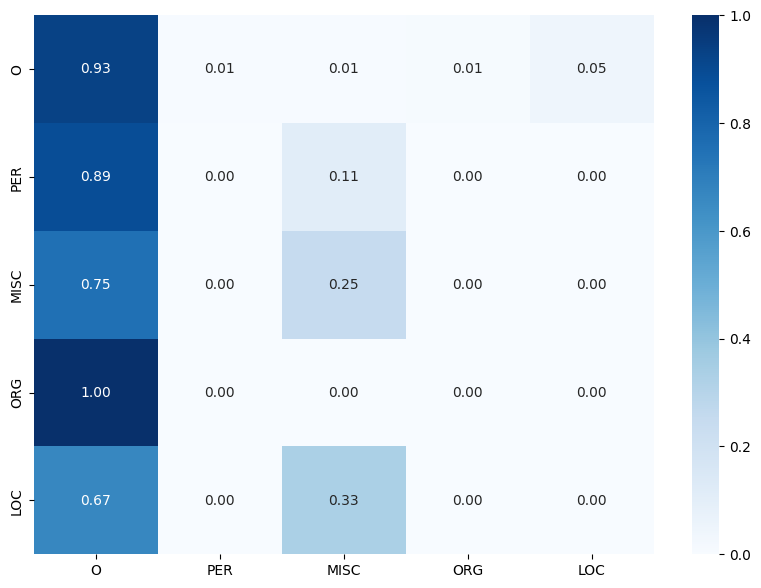

In [179]:
t = 19+14+51+5+43+14+46 #2334
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

              precision    recall  f1-score   support

         LOC       0.06      0.10      0.08        87
        MISC       0.05      0.07      0.06        59
           O       0.86      0.88      0.87      1993
         ORG       0.10      0.06      0.07        69
         PER       0.16      0.04      0.06       126

    accuracy                           0.76      2334
   macro avg       0.25      0.23      0.23      2334
weighted avg       0.75      0.76      0.75      2334



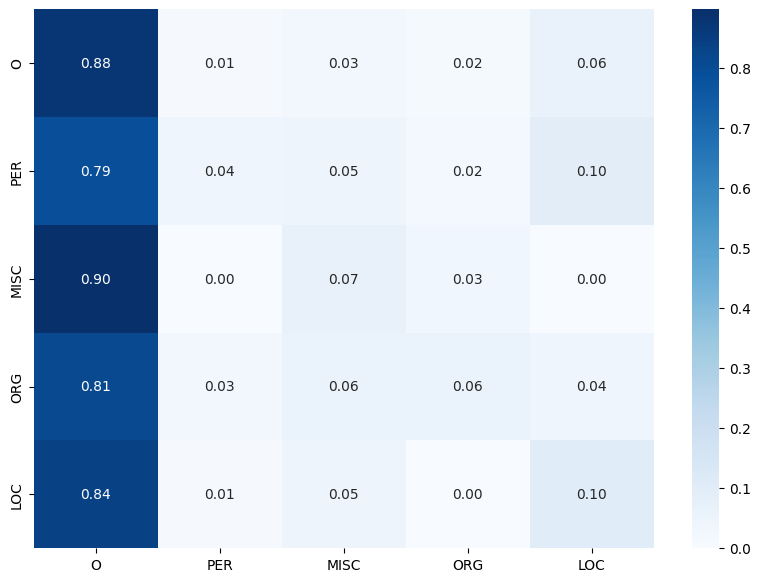

In [180]:
t = 2334# 19+14 +51+5#+43+14+46
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

              precision    recall  f1-score   support

         LOC       0.06      0.12      0.08         8
        MISC       0.11      0.20      0.14         5
           O       0.89      0.91      0.90       256
         ORG       0.00      0.00      0.00         7
         PER       0.00      0.00      0.00        13

    accuracy                           0.81       289
   macro avg       0.21      0.25      0.23       289
weighted avg       0.79      0.81      0.80       289



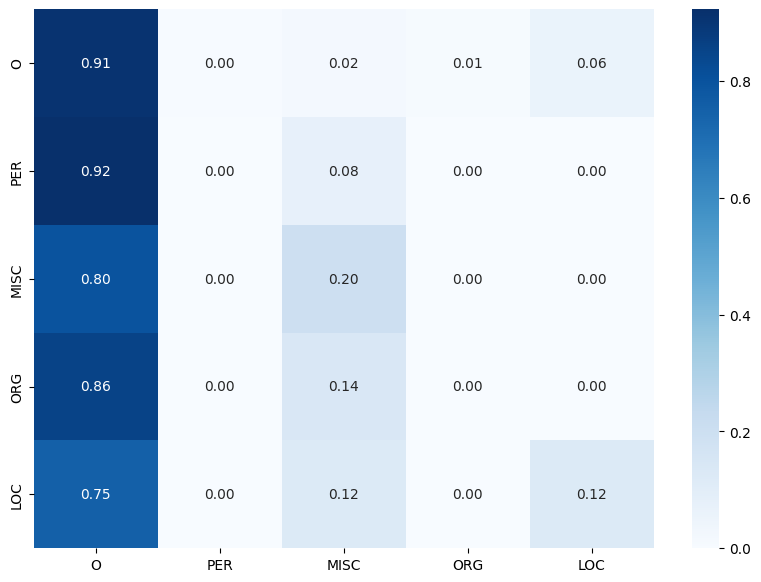

In [181]:
# TODO: Change num_files to number of files in the training set
num_files = 10 
t = val_metadata_doc[:num_files, 0].sum()
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

In [63]:
total_row_votes = votes_all.sum(axis=1).reshape(-1,1)
total_row_votes = np.where(
    total_row_votes == 0,
    1,
    total_row_votes
)
confidence_all_votes = fitness_votes_all / total_row_votes

In [65]:
np.array(predict)[range(2,5)]

array(['O', 'O', 'O', ..., 'O', 'O', 'O'], dtype='<U4')

In [67]:
confidences_votes

[(0, 1.0, [14, 15, 16], array(['LOC', 'LOC', 'O'], dtype='<U4')),
 (2, 1.0, [43, 44, 45], array(['ORG', 'ORG', 'ORG'], dtype='<U4')),
 (2, 1.0, [54, 55, 56, 57], array(['O', 'O', 'PER', 'PER'], dtype='<U4')),
 (4, 1.0, [24, 25, 26], array(['ORG', 'O', 'O'], dtype='<U4')),
 (7, 1.0, [37, 38, 39, 40], array(['O', 'O', 'LOC', 'O'], dtype='<U4'))]

Sort confidences_votes by confidence (1) and length of sentence (2)

In [68]:
# Create a custom function to sort confidences_votes by confidence (1) and length of sentence (2). The function will used by sorted() function.
from functools import cmp_to_key
def sort_confidence_votes(a, b):
    # Sort by confidence
    if a[1] > b[1]:
        return -1
    elif a[1] < b[1]:
        return 1
    else:
        # Sort by length of sentence
        if len(a[2]) > len(b[2]):
            return -1
        elif len(a[2]) < len(b[2]):
            return 1
        else:
            return 0
        
sorted_confidence_votes = sorted(confidences_votes, key=cmp_to_key(sort_confidence_votes))
sorted_confidence_votes

[(2, 1.0, [54, 55, 56, 57], array(['O', 'O', 'PER', 'PER'], dtype='<U4')),
 (7, 1.0, [37, 38, 39, 40], array(['O', 'O', 'LOC', 'O'], dtype='<U4')),
 (0, 1.0, [14, 15, 16], array(['LOC', 'LOC', 'O'], dtype='<U4')),
 (2, 1.0, [43, 44, 45], array(['ORG', 'ORG', 'ORG'], dtype='<U4')),
 (4, 1.0, [24, 25, 26], array(['ORG', 'O', 'O'], dtype='<U4'))]

In [81]:
# TODO 
# Create a file with only text
# Get Documents using in the training
# Extract text regarding top sorted_confidence_votes
# Add Entities to the text
# Save the file
# Retrain the model

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.


In [82]:
selected_indices_val[2]

596

In [83]:
val_metadata_doc[2][3]

3

In [89]:
index_doc = 7
spacy_doc_index = selected_indices_val[val_metadata_doc[index_doc][3]]
for index_token, token in enumerate(spacy_ner_doc_val[spacy_doc_index]):
    print(f"{index_token:{3}} {token.text:{12}} {token.pos_:{10}} {token.dep_:{10}} {token.ent_iob_:{10}} {token.ent_type_:{10}}")

  0 El           DET        det        O                    
  1 ciclista     NOUN       nsubj      O                    
  2 colombiano   ADJ        amod       O                    
  3 Iván         PROPN      appos      B          PER       
  4 Parra        PROPN      flat       I          PER       
  5 ,            PUNCT      punct      O                    
  6 del          ADP        case       O                    
  7 Seguros      PROPN      nmod       B          ORG       
  8 Vitalicio    PROPN      flat       I          ORG       
  9 ,            PUNCT      punct      O                    
 10 no           ADV        advmod     O                    
 11 tomará       VERB       ROOT       O                    
 12 mañana       ADV        advmod     O                    
 13 la           DET        det        O                    
 14 salida       NOUN       obj        O                    
 15 en           ADP        case       O                    
 16 la           DET    

In [107]:
limit_new_documents = int(metadata_doc.shape[0]*0.2)

In [109]:
# Remove entities
# Add Entities predicted by the model
# New spacy docs
from spacy.attrs import POS, DEP
np_array = doc.to_array([POS,DEP])
from spacy.tokens import Doc
from spacy.tokens import Span
val_metadata_doc
new_spacy_docs = []
for condidence_doc in sorted_confidence_votes[:limit_new_documents]:
    index_doc = condidence_doc[0]
    segment_tokens = condidence_doc[2]
    segment_label_tokens = condidence_doc[3]
    spacy_doc_index = selected_indices_val[val_metadata_doc[index_doc][3]]
    spacy_doc = spacy_ner_doc_val[spacy_doc_index]

    # Create a empty spacy doc
    words = [spacy_doc[index].text for index in segment_tokens]
    spaces = [spacy_doc[index].whitespace_ for index in segment_tokens]
    pos = [spacy_doc[index].pos_ for index in segment_tokens]
    deps = [spacy_doc[index].dep_ for index in segment_tokens]

    new_spacy_doc = Doc(spacy_doc.vocab, words=words, spaces=spaces, pos=pos, deps=deps)
    # Add the entities
    prev_label = None
    next_label = None
    start_entity = -1
    end_index = 0
    for index, label in enumerate(segment_label_tokens):
        if prev_label != label:
            start_index = index
        if index + 1 < len(segment_label_tokens):
            next_label = segment_label_tokens[index + 1]
        else:
            next_label = None

        if label != "O":
            if next_label != label:
                end_index = index + 1
                new_spacy_doc.set_ents([Span(new_spacy_doc, start_index, end_index, label)], default="outside")
        prev_label = label

    new_spacy_docs.append(new_spacy_doc)

In [110]:
for index_token, token in enumerate(new_spacy_docs[0]):
    print(f"{index_token:{3}} {token.text:{12}} {token.pos_:{10}} {token.tag_:{10}} {token.dep_:{10}} {token.ent_iob_:{10}} {token.ent_type_:{10}}")

  0 BNP          PROPN                 nmod       O                    
  1 sobre        ADP                   case       O                    
  2 las          DET                   det        B          PER       
  3 dos          NUM                   nummod     I          PER       


-  Expand candidates words
-  Expand update doc_dataset, target_doc and metadata_doc
- Use rules has parent population

In [111]:
# Create new corpus from new spacy docs
corpus_new = Corpus.from_spacy_docs(
    new_spacy_docs,
    total_samples=len(new_spacy_docs),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    emb_size=embedding_size
)

  0%|          | 0/2 [00:00<?, ?it/s]

In [120]:
# Expand candidate words
candidate_words_expand = create_candidate_words(
    corpus=corpus_new,
    candidate_words=candidate_words,
    save_path="data/train/esp.train.candidate_words_new.txt",
)      
print("Expand candidate words", candidate_words.shape)
print("Expand candidate words", candidate_words_expand.shape)    

Expand candidate words (171, 33)
Expand candidate words (180, 33)


In [121]:
corpus_new.to_text_array(
    input_filename="input_new.txt",
    target_filename="target_new.txt",
    metadata_filename="metadata_new.txt",
)

In [125]:
doc_dataset_new, doc_target, doc_metadata_new = read_input_txt(
    input_filename="input_new.txt",
    target_filename="target_new.txt",
    metadata_filename="metadata_new.txt",
    num_docs=len(new_spacy_docs),
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
)

In [161]:
doc_dataset_expand = np.vstack((doc_dataset, doc_dataset_new))
target_doc_expand = np.vstack((target_doc, doc_target))
metadata_doc_expand = np.vstack((metadata_doc, doc_metadata_new))

In [132]:
new_parent_populations = create_parent_population(
    400,
    corpus_1.documents + corpus_new.documents,
    cromossome_size=max_len,
    base_population=array_rules
)

  0%|          | 0/12 [00:00<?, ?it/s]

In [136]:
new_parent_populations.shape

(400, 241)

In [137]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary
from ga_ner.utils.numba import select, fitness
gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)

ga_ner = GANER(
    map_inv_entity=None,#map_inv_entity
    n_population=400,
    max_len=max_len,
    mask_id=0,#corpus_1.documents[0].mask_id
    unknown_id=0,#corpus_1.documents[0].unk_id
    candidate_words=candidate_words_expand,
    random_state=42,
    n_top=100,
    threshold=0.8,
    select=select,
    fitness=fitness,
    num_threads=16,
    embedding_size=embedding_size,
)
ga_ner.train(
    doc_dataset_expand,
    target_doc_expand,
    metadata_doc_expand,
    max_iter=1000,
    tol=15,
    base_population=new_parent_populations,
    num_islands=4,
    num_threads=16,
)

# 2015_Book_IntroductionToEvolutionaryComp.pdf 80, 108, 120, 145,294

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving 135 individuals
Saving 117 individuals
Saving 115 individuals
Saving 113 individuals
Saving 119 individuals
Saving 118 individuals
Saving 121 individuals
Saving 126 individuals
Saving 132 individuals
Saving 139 individuals
Saving 143 individuals
Saving 146 individuals
Saving 160 individuals
Saving 164 individuals
Saving 169 individuals
Saving 174 individuals
Saving 178 individuals
Saving 181 individuals
Saving 219 individuals
Saving 218 individuals
Saving 222 individuals
Saving 223 individuals
Saving 229 individuals
Saving 225 individuals
Saving 244 individuals
Saving 243 individuals
Saving 244 individuals
Saving 240 individuals
Saving 242 individuals
Saving 243 individuals
Saving 251 individuals
Saving 263 individuals
Saving 262 individuals
Saving 259 individuals
Saving 262 individuals
Saving 258 individuals
Saving 260 individuals
Saving 260 individuals
Saving 260 individuals
Saving 263 individuals
Saving 278 individuals
Saving 283 individuals


In [149]:
target_data_all = get_all_targets(val_doc_dataset, val_target_doc, val_metadata_doc,entity_map)
predict, votes_all, fitness_votes_all = majority_vote(
    val_doc_dataset, val_target_doc, val_metadata_doc, entity_map, len(index_rules))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00         8
        MISC       0.00      0.00      0.00         5
           O       0.90      0.95      0.92       256
         ORG       0.20      0.14      0.17         7
         PER       0.50      0.15      0.24        13

    accuracy                           0.85       289
   macro avg       0.32      0.25      0.26       289
weighted avg       0.82      0.85      0.83       289



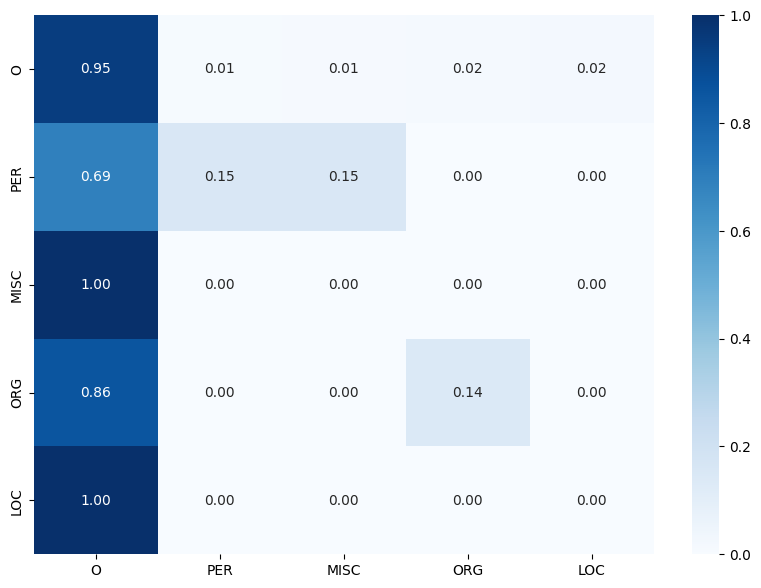

In [150]:
# TODO: Change num_files to number of files in the training set
num_files = 10 
t = val_metadata_doc[:num_files, 0].sum()
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

              precision    recall  f1-score   support

         LOC       0.08      0.06      0.07        87
        MISC       0.09      0.14      0.11        59
           O       0.87      0.90      0.89      1993
         ORG       0.11      0.04      0.06        69
         PER       0.22      0.15      0.18       126

    accuracy                           0.79      2334
   macro avg       0.27      0.26      0.26      2334
weighted avg       0.76      0.79      0.77      2334



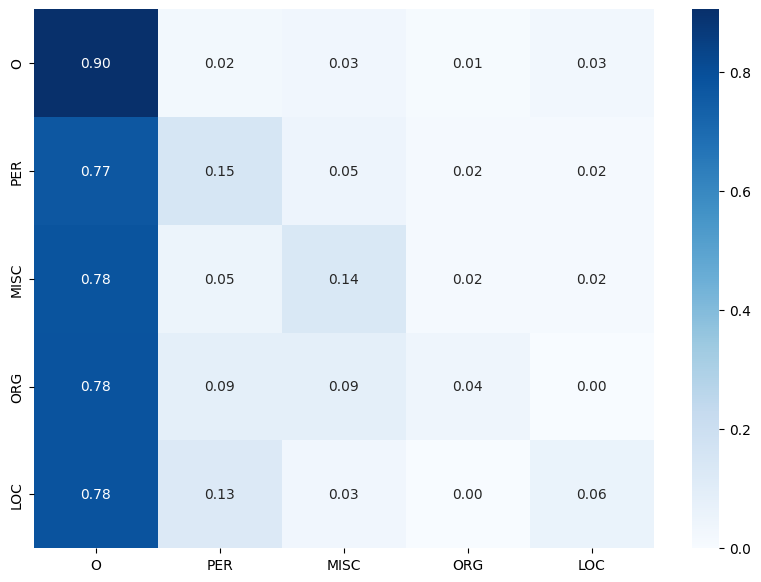

In [151]:
# TODO: Change num_files to number of files in the training set
print(classification_report(entity_map[target_data_all], predict))
print_cm(entity_map[target_data_all], predict, entity_map)

In [152]:
total_row_votes = votes_all.sum(axis=1).reshape(-1,1)
total_row_votes = np.where(
    total_row_votes == 0,
    1,
    total_row_votes
)
confidence_all_votes = fitness_votes_all / total_row_votes

In [153]:
# Extract segments which confidences are higher than 0.8
confidences_votes = []
start_doc = 0
min_segment_len = 3
filter_votes = np.any(confidence_all_votes > 0.8, axis=1).reshape(-1,1)
for index_row, doc_len in enumerate(val_metadata_doc[:num_files, 0]):
    end_doc = start_doc + doc_len
    # If filter are consecutive and have a minimum length then add to confidences_votes
    current_secuence = 0
    for filter_votes_index, secuencuence_index in enumerate(range(start_doc, end_doc)):
        if filter_votes[secuencuence_index]:
            current_secuence += 1
        else:
            if current_secuence >= min_segment_len:
                
                confidences_votes.append(( 
                    index_row, 
                    confidence_all_votes[
                        range(secuencuence_index - current_secuence, secuencuence_index)
                        ].max(axis=1).mean(),
                    list(range(filter_votes_index - current_secuence, filter_votes_index)),
                    np.array(predict)[range(secuencuence_index - current_secuence, secuencuence_index)]
                    ))
            current_secuence = 0

    start_doc = end_doc

In [154]:
sorted_confidence_votes = sorted(confidences_votes, key=cmp_to_key(sort_confidence_votes))
sorted_confidence_votes

[(0, 1.0, [6, 7, 8], array(['LOC', 'O', 'ORG'], dtype='<U4')),
 (0, 1.0, [14, 15, 16], array(['LOC', 'O', 'O'], dtype='<U4')),
 (2, 1.0, [43, 44, 45], array(['O', 'ORG', 'O'], dtype='<U4')),
 (5, 1.0, [6, 7, 8], array(['O', 'PER', 'O'], dtype='<U4')),
 (7,
  0.8333333134651184,
  [6, 7, 8],
  array(['MISC', 'MISC', 'MISC'], dtype='<U4'))]

In [155]:
limit_new_documents = int(metadata_doc.shape[0]*0.2)

In [156]:
# Remove entities
# Add Entities predicted by the model
# New spacy docs
from spacy.attrs import POS, DEP
np_array = doc.to_array([POS,DEP])
from spacy.tokens import Doc
from spacy.tokens import Span
val_metadata_doc
new_spacy_docs = []
for condidence_doc in sorted_confidence_votes[:limit_new_documents]:
    index_doc = condidence_doc[0]
    segment_tokens = condidence_doc[2]
    segment_label_tokens = condidence_doc[3]
    spacy_doc_index = selected_indices_val[val_metadata_doc[index_doc][3]]
    spacy_doc = spacy_ner_doc_val[spacy_doc_index]

    # Create a empty spacy doc
    words = [spacy_doc[index].text for index in segment_tokens]
    spaces = [spacy_doc[index].whitespace_ for index in segment_tokens]
    pos = [spacy_doc[index].pos_ for index in segment_tokens]
    deps = [spacy_doc[index].dep_ for index in segment_tokens]

    new_spacy_doc = Doc(spacy_doc.vocab, words=words, spaces=spaces, pos=pos, deps=deps)
    # Add the entities
    prev_label = None
    next_label = None
    start_entity = -1
    end_index = 0
    for index, label in enumerate(segment_label_tokens):
        if prev_label != label:
            start_index = index
        if index + 1 < len(segment_label_tokens):
            next_label = segment_label_tokens[index + 1]
        else:
            next_label = None

        if label != "O":
            if next_label != label:
                end_index = index + 1
                new_spacy_doc.set_ents([Span(new_spacy_doc, start_index, end_index, label)], default="outside")
        prev_label = label

    new_spacy_docs.append(new_spacy_doc)

In [159]:
for index_token, token in enumerate(new_spacy_docs[1]):
    print(f"{index_token:{3}} {token.text:{12}} {token.pos_:{10}} {token.tag_:{10}} {token.dep_:{10}} {token.ent_iob_:{10}} {token.ent_type_:{10}}")

  0 may          NOUN                  appos      B          LOC       
  1 (            PUNCT                 punct      O                    
  2 EFE          PROPN                 flat       O                    


In [ ]:
# Create new corpus from new spacy docs
corpus_new = Corpus.from_spacy_docs(
    new_spacy_docs,
    total_samples=len(new_spacy_docs),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    emb_size=embedding_size
)

  0%|          | 0/2 [00:00<?, ?it/s]

In [160]:
# Expand candidate words
candidate_words_expand = create_candidate_words(
    corpus=corpus_new,
    candidate_words=candidate_words,
    save_path="data/train/esp.train.candidate_words_new.txt",
)      
print("Expand candidate words", candidate_words.shape)
print("Expand candidate words", candidate_words_expand.shape)    

Expand candidate words (171, 33)
Expand candidate words (180, 33)


              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00         8
        MISC       0.00      0.00      0.00         5
           O       0.90      0.95      0.92       256
         ORG       0.20      0.14      0.17         7
         PER       0.50      0.15      0.24        13

    accuracy                           0.85       289
   macro avg       0.32      0.25      0.26       289
weighted avg       0.82      0.85      0.83       289



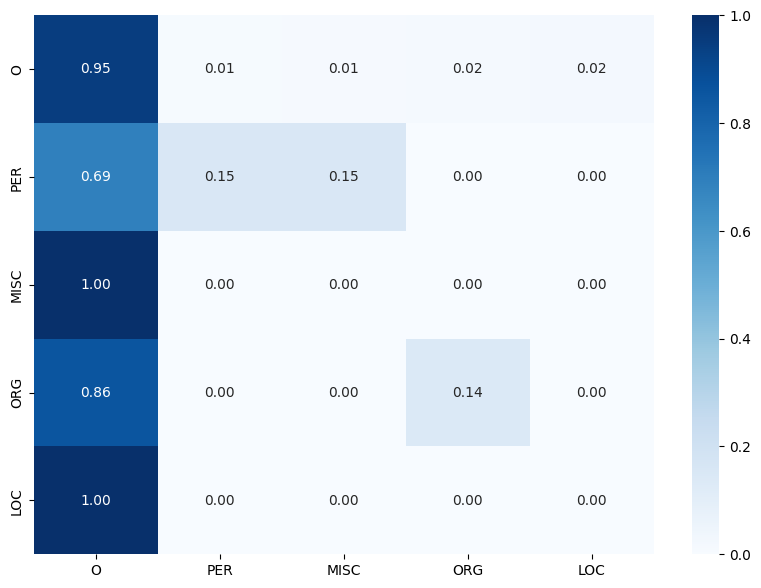

In [ ]:
# TODO: Change num_files to number of files in the training set
num_files = 10 
t = val_metadata_doc[:num_files, 0].sum()
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

In [164]:
corpus_new.to_text_array(
    input_filename="input_new_1.txt",
    target_filename="target_new_1.txt",
    metadata_filename="metadata_new_1.txt",
)

In [166]:
doc_dataset_new, doc_target, doc_metadata_new = read_input_txt(
    input_filename="input_new_1.txt",
    target_filename="target_new_1.txt",
    metadata_filename="metadata_new_1.txt",
    num_docs=len(new_spacy_docs),
    max_size_doc=max_size_doc,
    embedding_size=embedding_size,
)

In [167]:
doc_dataset_expand_2 = np.vstack((doc_dataset_expand, doc_dataset_new))
target_doc_expand_2 = np.vstack((target_doc_expand, doc_target))
metadata_doc_expand_2 = np.vstack((metadata_doc_expand, doc_metadata_new))

In [168]:
new_parent_populations = create_parent_population(
    400,
    corpus_1.documents + corpus_new.documents,
    cromossome_size=max_len,
    base_population=array_rules
)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [169]:
new_parent_populations.shape

(400, 241)

In [170]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary
from ga_ner.utils.numba import select, fitness
gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)

ga_ner = GANER(
    map_inv_entity=None,#map_inv_entity
    n_population=400,
    max_len=max_len,
    mask_id=0,#corpus_1.documents[0].mask_id
    unknown_id=0,#corpus_1.documents[0].unk_id
    candidate_words=candidate_words_expand,
    random_state=42,
    n_top=100,
    threshold=0.8,
    select=select,
    fitness=fitness,
    num_threads=16,
    embedding_size=embedding_size,
)
ga_ner.train(
    doc_dataset_expand_2,
    target_doc_expand_2,
    metadata_doc_expand_2,
    max_iter=1000,
    tol=15,
    base_population=new_parent_populations,
    num_islands=4,
    num_threads=16,
)

# 2015_Book_IntroductionToEvolutionaryComp.pdf 80, 108, 120, 145,294

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving 194 individuals
Saving 183 individuals
Saving 174 individuals
Saving 175 individuals
Saving 172 individuals
Saving 168 individuals
Saving 171 individuals
Saving 167 individuals
Saving 166 individuals
Saving 168 individuals
Saving 174 individuals
Saving 176 individuals
Saving 183 individuals
Saving 193 individuals
Saving 195 individuals
Saving 196 individuals
Saving 215 individuals
Saving 210 individuals
Saving 215 individuals
Saving 210 individuals
Saving 220 individuals
Saving 228 individuals
Saving 230 individuals
Saving 243 individuals
Saving 242 individuals
Saving 243 individuals
Saving 237 individuals
Saving 249 individuals
Saving 265 individuals
Saving 275 individuals


1. Save Spacy Documents to training data
2. Load training data
3. Save and load data as arrays
4. Generate parent population
5. Train model
6. Save evolutions of model
7. Test model with test data
    8. Save Spacy Documents to test data
    9. Load test data
    10. Save and load data as arrays
    11. Test model
    1. Save results
        1. Save text
        2. Save consufion matrix i